In [1]:
"""
FOR TESTING PURPOSES
"""
%load_ext autoreload
%autoreload 2

In [2]:
"""
Import relevant modules
"""

import pathlib

import SimpleITK as sitk
import numpy as np

from platipy.imaging.registration.registration import apply_field

from platipy.imaging.visualisation.tools import ImageVisualiser, project_onto_arbitrary_plane, generate_animation_from_image_sequence

from platipy.imaging.utils.tools import label_to_roi, get_com

from platipy.imaging.tests.pull_data import get_lung_data

"""
Deformation field operations
"""
from platipy.imaging.deformation_fields.deformation_field_operations import (
get_bone_mask,
get_external_mask,
generate_field_shift,
generate_field_asymmetric_contract,
generate_field_asymmetric_extend,
generate_field_expand,
generate_field_radial_bend
)

%matplotlib notebook

In [3]:
"""
Download a sample case
"""
get_lung_data(number_of_patients=1)

2021-02-09 11:16:21.674 | DEBUG    | platipy.imaging.tests.pull_data:fetch_data:117 - Path exists: /home/robbie/Work/4_Software/platipy/platipy/imaging/tests/data/LCTSC/LCTSC-Test-S1-101, won't fetch data


{'LCTSC-Test-S1-101': '/home/robbie/Work/4_Software/platipy/platipy/imaging/tests/data/LCTSC/LCTSC-Test-S1-101'}

In [4]:
"""
Read in some images and structures for this demonstration
We are using a lung radiotherapy dataset comprising CT and RTSTRUCT
"""

image_ct = sitk.ReadImage("../../imaging/tests/data/LCTSC/LCTSC-Test-S1-101/CT.nii.gz")

structure_list = ["Heart", "Esophagus", "Lung_L", "Lung_R", "SpinalCord"]
label_images = {i:sitk.ReadImage(f"../../imaging/tests/data/LCTSC/LCTSC-Test-S1-101/Struct_{i}.nii.gz") for i in structure_list}

In [55]:
"""
Deformation 1: SHIFTING SPECIFIC STRUCTURES

We define a vector shift and then apply smoothing for more realistic deformation.
We use a bone mask to keep bony anatomy consistent.
"""

label_shift, shift_transform, shift_dvf = generate_field_shift(label_images["Heart"], vector_shift=(0,0,20), gaussian_smooth=5)

In [56]:
"""
We can apply the transformation to the image, or to the other structures
"""

image_ct_deformed = apply_field(image_ct, shift_transform, structure=False, default_value=-1000)

<IPython.core.display.Javascript object>


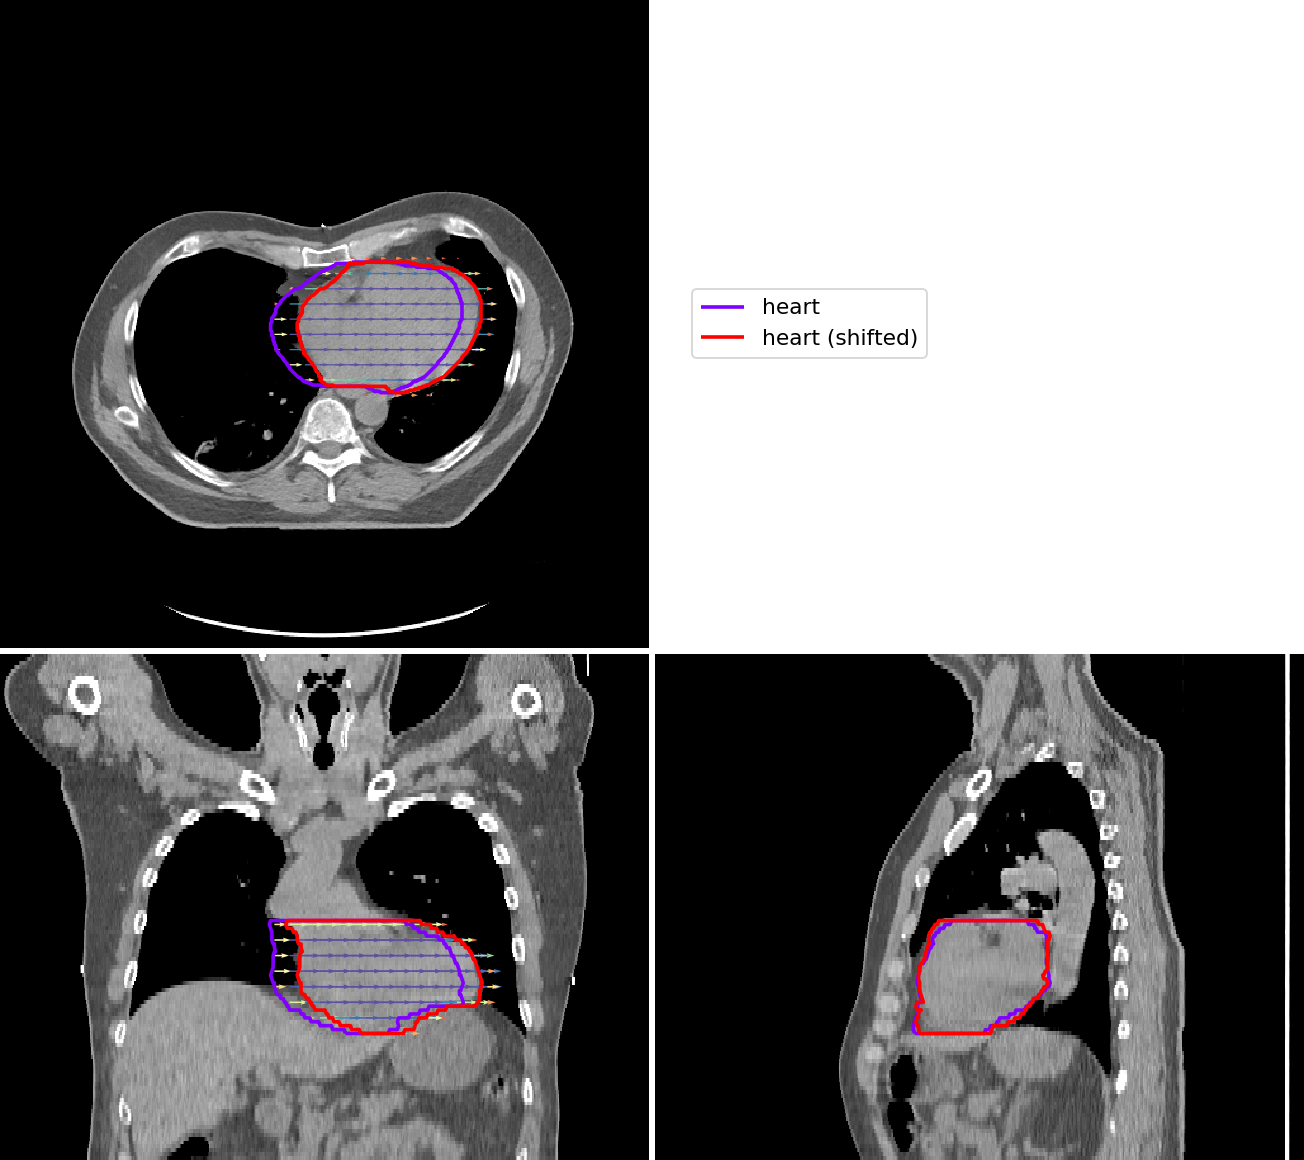

In [57]:
"""
One way to display is to overlay the images and vector field
"""
vis = ImageVisualiser(image=image_ct_deformed, cut=get_com(label_shift), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_vector_overlay(shift_dvf, arrow_scale=1, subsample=(4,12,12), color_function="magnitude")
vis.add_contour({"heart":label_images["Heart"], "heart (shifted)":label_shift})



fig = vis.show()

<IPython.core.display.Javascript object>


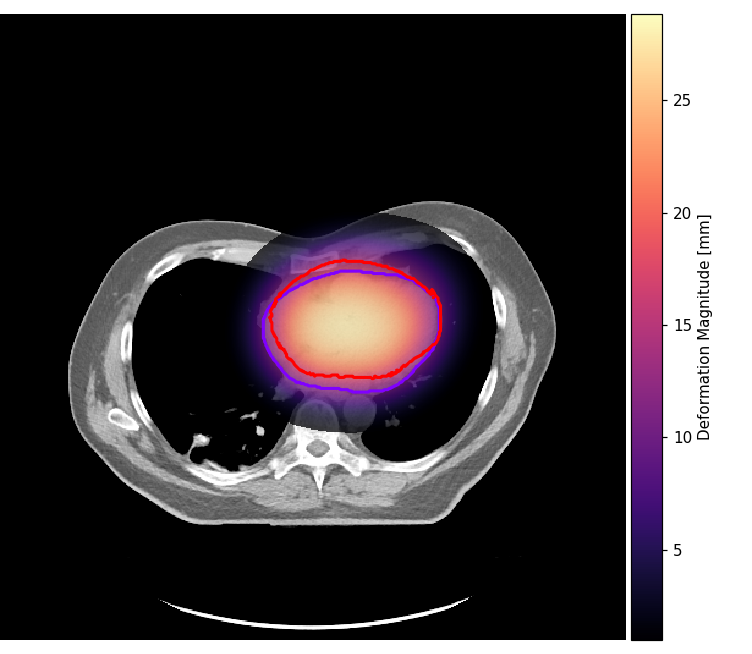

In [11]:
"""
Another method is displaying both the original and deformed image with contours
We can also display a map of the vector magnitude
"""

vis = ImageVisualiser(image = image_ct, axis='z', cut=50, figure_size_in=6)
vis.add_scalar_overlay(sitk.VectorMagnitude(shift_dvf), colormap=plt.cm.magma, name="Deformation Magnitude [mm]", min_value=1)
vis.add_contour({"heart":label_images["Heart"], "heart (shifted)":label_shift})
fig = vis.show()


In [9]:
"""
These methods are widely applicable to other deformations
There are a few available:
    generate_field_shift
    generate_field_asymmetric_contract
    generate_field_asymmetric_extend
    generate_field_expand

Each of these will be demonstrated below, with some notes

"""

'\nThese methods are widely applicable to other deformations\nThere are a few available:\n    generate_field_shift\n    generate_field_asymmetric_contract\n    generate_field_asymmetric_extend\n    generate_field_expand\n\nEach of these will be demonstrated below, with some notes\n\n'

In [58]:
"""
generate_field_asymmetric_contract

This function takes a structure and contracts in each dimension individually (axial, coronal, sagittal).
This contraction can be either positive of negative to define which side of the structure undergoes contraction:
    (+/-, +/-, +/-) = contract volume at (inf/sup, post/ant, r/l) border in patient coordinates.
"""

label_contract, contract_transform, contract_dvf = generate_field_asymmetric_contract(label_images["Lung_L"]+label_images["Lung_R"], vector_asymmetric_contract=(0,0,30), gaussian_smooth=5)

image_ct_deformed = apply_field(image_ct, contract_transform, structure=False, default_value=-1000)

<IPython.core.display.Javascript object>


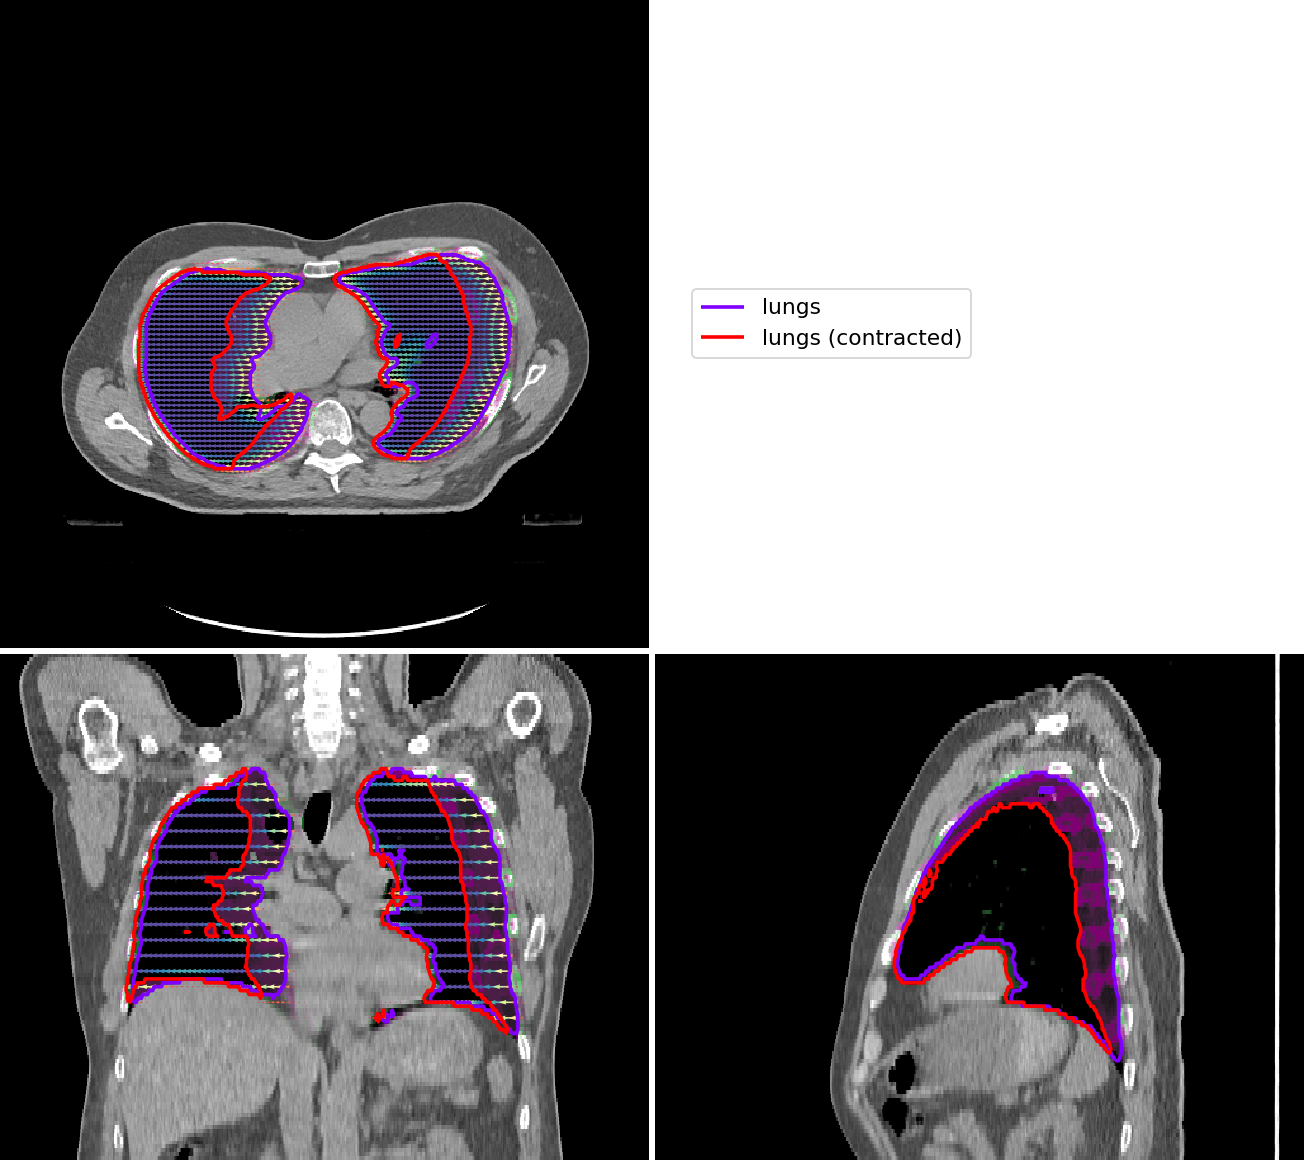

In [59]:
vis = ImageVisualiser(image=image_ct, cut=get_com(label_images["Lung_L"]), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_vector_overlay(contract_dvf, arrow_scale=0.5, subsample=4, color_function='magnitude')
vis.add_contour({"lungs":label_images["Lung_L"]+label_images["Lung_R"], "lungs (contracted)":label_contract})

fig = vis.show()

In [66]:
"""
generate_field_asymmetric_extend

This function takes a structure and extends in each dimension individually (axial, coronal, sagittal).
This extendion can be either positive of negative to define which side of the structure undergoes extendion:
    (+/-, +/-, +/-) = extend volume at (sup/inf, ant/post, l/r) border in patient coordinates.
"""

label_extend, extend_transform, extend_dvf = generate_field_asymmetric_extend(label_images["Lung_L"], vector_asymmetric_extend=(0, 0, 30), gaussian_smooth=10)

image_ct_deformed = apply_field(image_ct, extend_transform, structure=False, default_value=-1000)

<IPython.core.display.Javascript object>


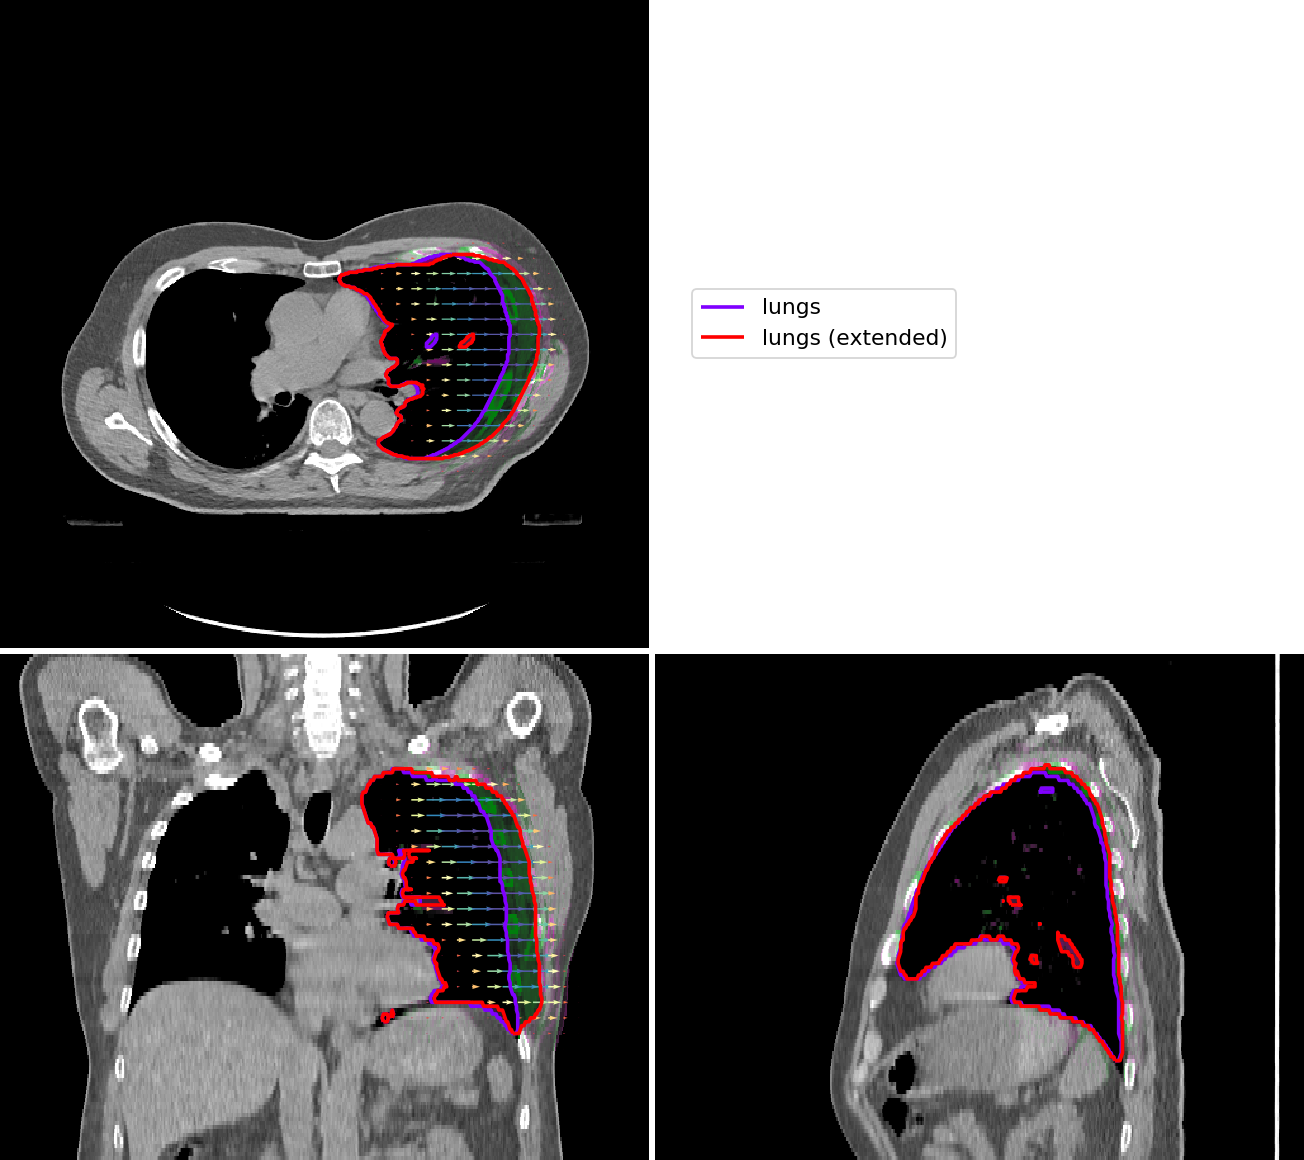

In [67]:
vis = ImageVisualiser(image=image_ct, cut=get_com(label_images["Lung_L"]), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_vector_overlay(extend_dvf, arrow_scale=0.5, subsample=(4,12,12), color_function='magnitude')
vis.add_contour({"lungs":label_images["Lung_L"], "lungs (extended)":label_extend})

fig = vis.show()

In [112]:
"""
generate_field_expand

This function takes a structure and expands or shrinks the structure.
The variable *expand* defines the expansion (or shrinking) in mm.
It can also be defined as a 3D vector, in which case the expansion is anisotropic.

Note - simultaneous expansion/shrinking in different directions is not yet supported!
"""

label_expand, expand_transform, expand_dvf = generate_field_expand(label_images["Heart"], bone_mask=False, expand=(-10,20,0), gaussian_smooth=2)

image_ct_deformed = apply_field(image_ct, expand_transform, structure=False, default_value=-1000)

Mixed factors: shrinking and expansion.


<IPython.core.display.Javascript object>


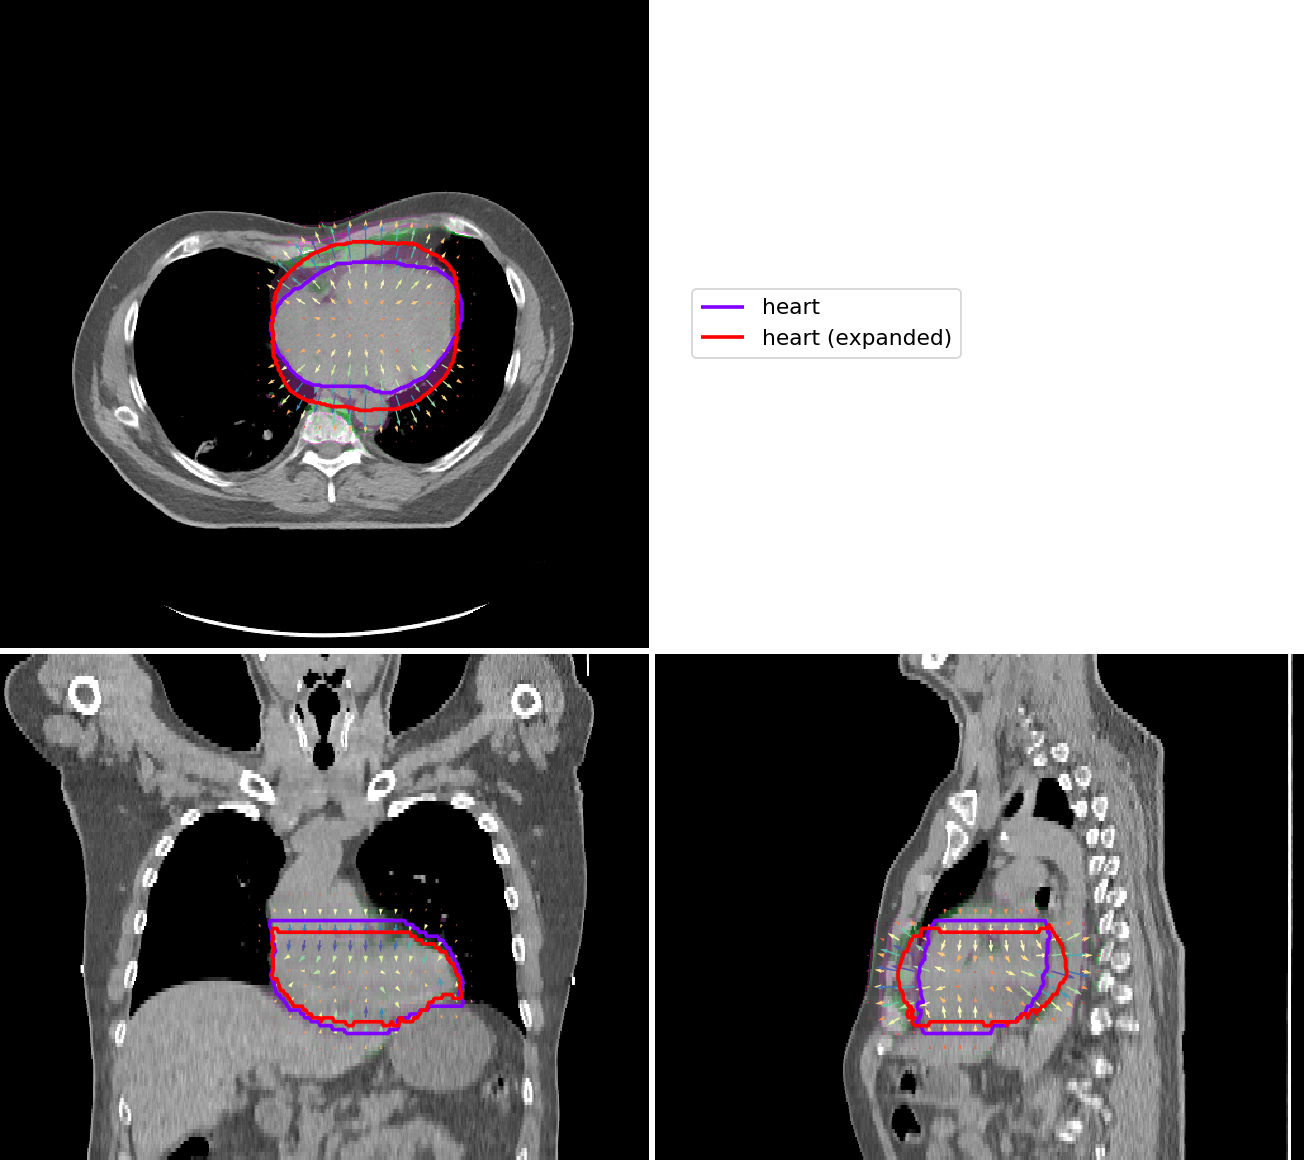

In [113]:
vis = ImageVisualiser(image=image_ct, cut=get_com(label_images["Heart"]), figure_size_in=10)

vis.add_comparison_overlay(image_ct_deformed)
vis.add_vector_overlay(expand_dvf, arrow_scale=1, subsample=(4,12,12), color_function='magnitude')
vis.add_contour({"heart":label_images["Heart"], "heart (expanded)":label_expand})

fig = vis.show()

<IPython.core.display.Javascript object>


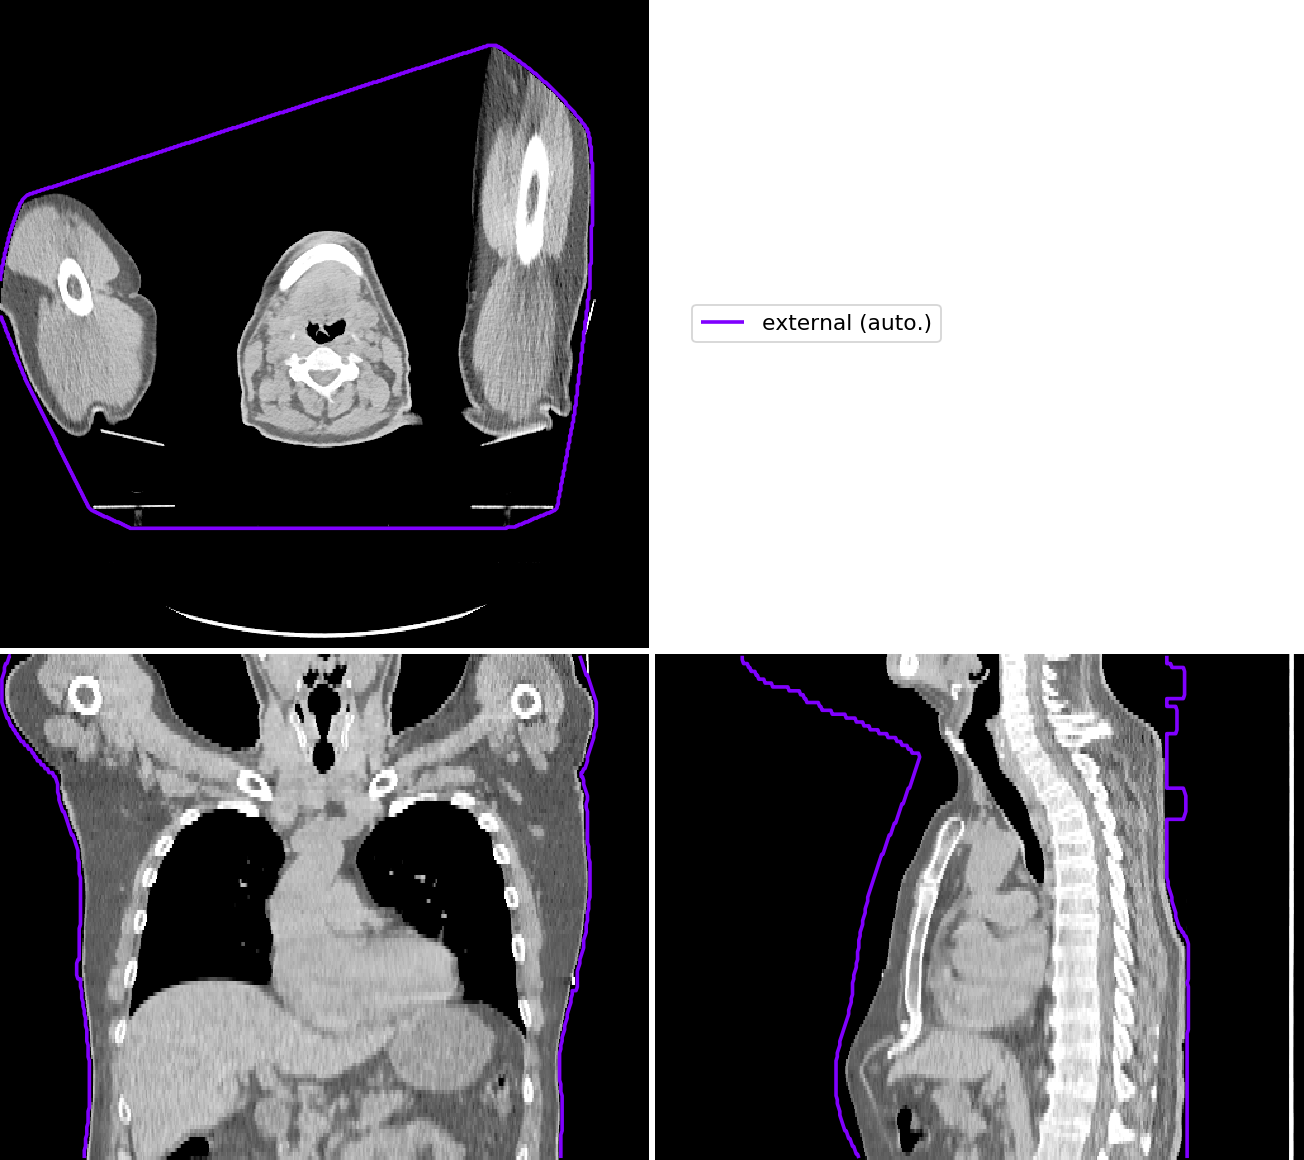

No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


In [115]:
external_mask = get_external_mask(image_ct, dilate=1)

vis = ImageVisualiser(image=image_ct, cut=(125, 256, 256), figure_size_in=10)
vis.add_contour({"external (auto.)":external_mask})

fig = vis.show()

In [120]:
"""
generate_field_radial_bend


"""

image_ct_bend, bend_transform, bend_dvf = generate_field_radial_bend(
    image_ct,
    external_mask,
    reference_point=get_com(label_images["Heart"]),
    axis_of_rotation=[1,0,0],
    scale=1,
    mask_bend_from_reference_point=("z", "inf"),
    gaussian_smooth=False,
)


<IPython.core.display.Javascript object>


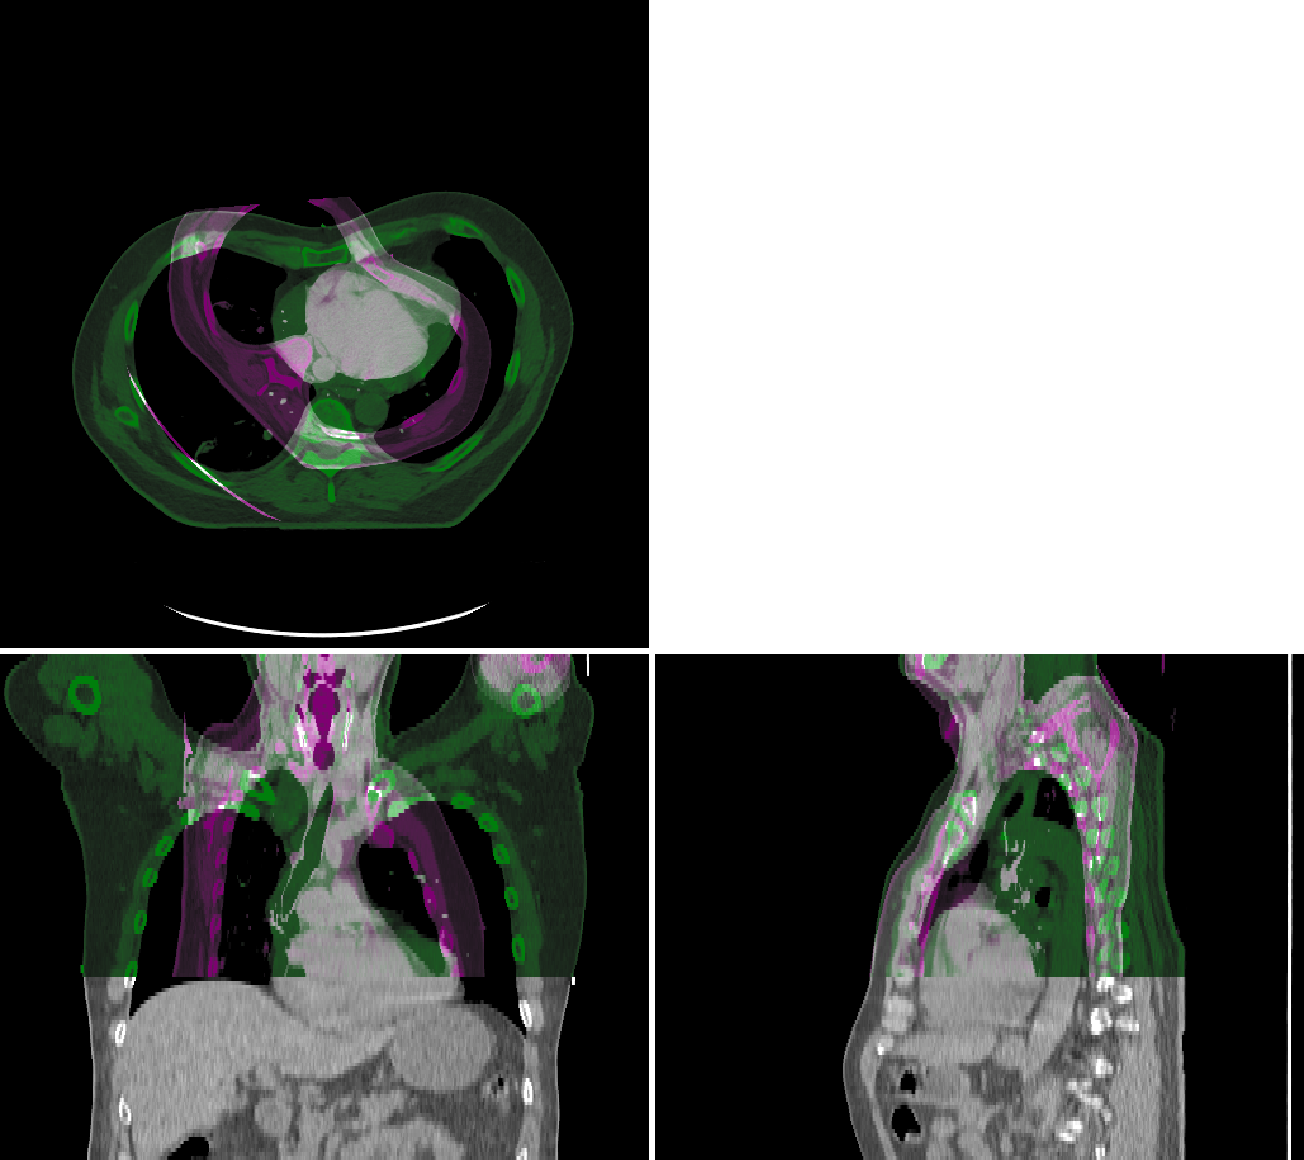

In [122]:
vis = ImageVisualiser(image=image_ct, cut=get_com(label_images["Heart"]), figure_size_in=10)

vis.add_comparison_overlay(image_ct_bend)
#vis.add_vector_overlay(bend_dvf, arrow_scale=1, subsample=(4,12,12), color_function='magnitude')

fig = vis.show()